### Quantity Theory of Money

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas_datareader.data import DataReader

In [6]:
start = '1959-12-01'
end = '2015-01-01'
m2 = DataReader('M2SL', 'fred', start=start, end=end)
cpi = DataReader('CPIAUCSL', 'fred', start=start, end=end)

In [7]:
# Exponentially Weighted Moving Averages
def ewma(series, beta, n_window):
    nobs = len(series)
    scalar = (1 - beta)/(1 + beta)
    ma = []
    k = np.arange(n_window, 0, -1)
    weights = np.r_[beta**k, 1, beta**k[::-1]]
    for t in range(n_window, nobs - n_window):
        window = series.iloc[t - n_window:t + n_window+1].values
        ma.append(scalar * np.sum(weights * window))
    return pd.Series(ma, name=series.name, index=series.iloc[n_window:-n_window].index)

In [8]:
m2_ewma = ewma(np.log(m2['M2SL'].resample("QS").mean()).diff().iloc[1:], 0.95, 10 * 4)
cpi_ewma = ewma(np.log(cpi['CPIAUCSL'].resample("QS").mean()).diff().iloc[1:], 0.95, 10 * 4)

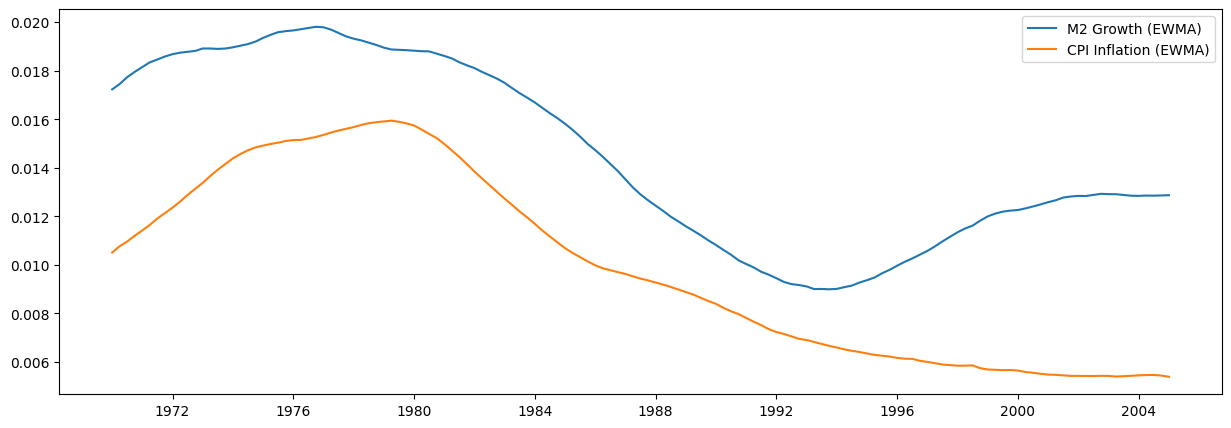

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(m2_ewma, label="M2 Growth (EWMA)")
ax.plot(cpi_ewma, label="CPI Inflation (EWMA)")
ax.legend()
plt.show()

In [10]:
endog = cpi_ewma
exog = sm.add_constant(m2_ewma)
model = sm.RecursiveLS(endog, exog)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               CPIAUCSL   No. Observations:                  141
Model:                    RecursiveLS   Log Likelihood                 692.878
Date:                Thu, 09 May 2024   R-squared:                       0.813
Time:                        19:52:07   AIC                          -1381.755
Sample:                    01-01-1970   BIC                          -1375.858
                         - 01-01-2005   HQIC                         -1379.358
Covariance Type:            nonrobust   Scale                            0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.001     -6.013      0.000      -0.004      -0.002
M2SL           0.9128      0.037     24.601      0.000       0.840       0.986
===================================================================================
Ljung-Box (L1) (Q):                 138.23   Jarque-Bera (JB):                18.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.30   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Parameters and covariance matrix estimates are RLS estimates conditional on the entire sample.
"""

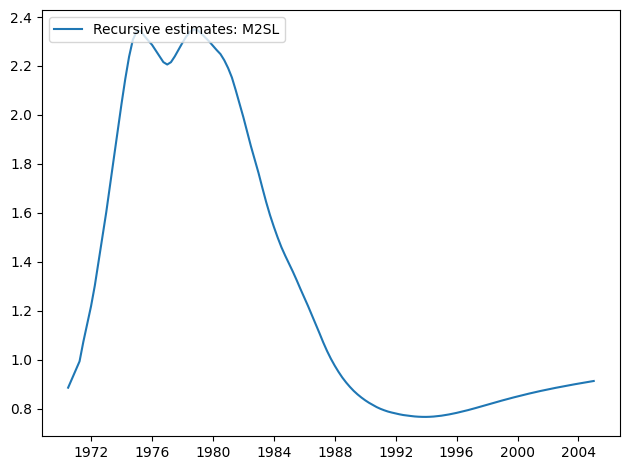

In [11]:
res.plot_recursive_coefficient(1, alpha=None);

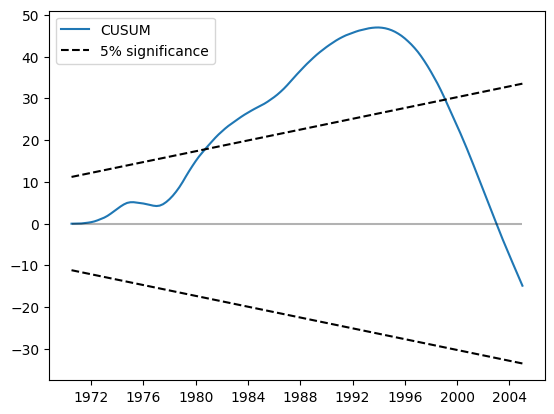

In [12]:
res.plot_cusum();

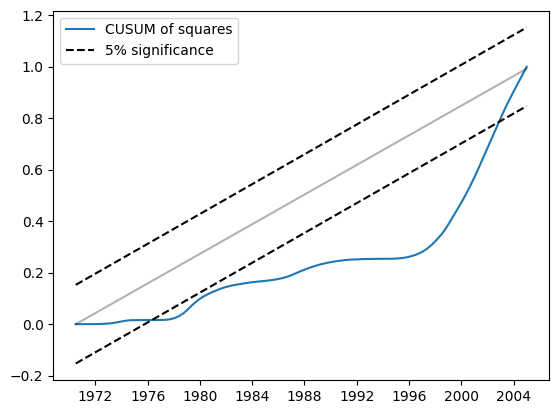

In [13]:
res.plot_cusum_squares();